In [1]:
# basic import statements
import os
import re
import gc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
warnings.filterwarnings("ignore")
from datetime import date 

#set max display in notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Show multiple output in console
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df = pd.read_csv('new_data_analysed_top25%.csv')
df.shape
df.head()

(6171281, 22)

,sku,condition,size,gender,sold_at,sold_price,source,size_value,brand,name,colorway,color,silhouette,retailprice,releasedate,is_collab,collaborator,quarter,average_sold_price,sku_count,percentage_difference,resale_flag
0,DD1399-101,is_new,7.5,men,2021-12-13,236.0,stockx,7.5,Nike,Nike Dunk High Syracuse (2021),White/Orange Blaze,white,Dunk,110.0,2021-03-10,False,NaN,4.0,197.367568,2.0,79.425061,Substantial Resale Premium
1,BQ7666-100,is_new,10,men,2021-07-12,169.0,stockx,10.0,Jordan,Jordan 8 SP Retro SE White Multicolor,White/Black-Red Orbit,white,Air Jordan 8,225.0,2019-09-18,False,NaN,3.0,160.363636,280.0,-28.727273,Discounted Resale
2,CK7214-100,is_new,11.5,men,2021-08-02,140.0,stockx,11.5,Nike,Nike Air Force 1 Low '07 LV8 White,White/White/White,white,Air Force 1,110.0,2020-07-20,False,NaN,3.0,120.000000,12.0,9.090909,Negligible Resale Premium
3,BQ6806-115,is_new,7,men,2021-06-21,123.0,stockx,7.0,Nike,Nike Blazer Mid 77 Vintage Pine Green,White/Pine Green,white,Blazer,100.0,2021-01-22,False,NaN,2.0,118.636364,49.0,18.636364,Negligible Resale Premium
4,DD9678-100,is_new,10,men,NaN,133.0,alias,10.0,Nike,Nike Air Max 90 Burlap,White/Cream-Burlap,cream,Air Max 90,120.0,2021-03-09,False,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[df.sku=='315122-111/CW2288-111']
df.shape

(25172, 22)

In [5]:
df['sold_at'] = pd.to_datetime(df['sold_at'], format='%Y-%m-%d', errors='coerce')
df.dtypes

sku                              object
condition                        object
size                             object
gender                           object
sold_at                  datetime64[ns]
sold_price                      float64
source                           object
size_value                      float64
brand                            object
name                             object
colorway                         object
color                            object
silhouette                       object
retailprice                     float64
releasedate                      object
is_collab                        object
collaborator                     object
quarter                         float64
average_sold_price              float64
sku_count                       float64
percentage_difference           float64
resale_flag                      object
dtype: object

In [8]:
df_filtered = df[df['sold_at'].dt.month != 12]
df_filtered.shape
df_filtered.head()

(22504, 22)

,sku,condition,size,gender,sold_at,sold_price,source,size_value,brand,name,colorway,color,silhouette,retailprice,releasedate,is_collab,collaborator,quarter,average_sold_price,sku_count,percentage_difference,resale_flag
320,315122-111/CW2288-111,is_new,9,men,2021-07-24,104.0,stockx,9.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,3.0,106.644377,2.0,-3.050566,Discounted Resale
1183,315122-111/CW2288-111,is_new,10.5,men,2021-07-06,148.0,stockx,10.5,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,3.0,107.605453,36.0,-2.176861,Discounted Resale
1401,315122-111/CW2288-111,is_new,11,men,2021-08-31,117.0,stockx,11.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,3.0,108.898575,5.0,-1.001295,Discounted Resale
1506,315122-111/CW2288-111,is_new,12,men,2021-10-04,94.0,stockx,12.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,4.0,106.606414,138.0,-3.085078,Discounted Resale
1965,315122-111/CW2288-111,is_new,9.5,men,2021-08-27,111.0,stockx,9.5,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,3.0,111.604118,23.0,1.458289,Negligible Resale Premium


In [14]:
df_filtered.dtypes

sku                              object
condition                        object
size                             object
gender                           object
sold_at                  datetime64[ns]
sold_price                      float64
source                           object
size_value                      float64
brand                            object
name                             object
colorway                         object
color                            object
silhouette                       object
retailprice                     float64
releasedate                      object
is_collab                        object
collaborator                     object
quarter                         float64
average_sold_price              float64
sku_count                       float64
percentage_difference           float64
resale_flag                      object
dtype: object

In [13]:
df_filtered['sold_price'] = pd.to_numeric(df_filtered['sold_price'], errors='coerce')

In [16]:
print(isinstance(df_filtered['sold_price'], pd.Series))
print(isinstance(df_filtered['sold_price'], np.ndarray))

True
False


In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Group the data by SKU, gender, condition, and size_value
grouped_data = df_filtered.groupby(['sku', 'gender', 'condition', 'size_value'])

# Define a function to apply Exponential Smoothing and forecast for each group
def forecast_group(group):
    # Instantiate the Exponential Smoothing model without seasonal components
    model = ExponentialSmoothing(group['sold_price'], trend='add')
    
    # Fit the model to the historical data for the group
    model_fit = model.fit()
    
    # Forecast the next month (12th month) for the group
    forecast_next_month = model_fit.forecast(steps=1)
    
    # Return the forecasted value
    return forecast_next_month

# Apply the forecast_group function to each group and get the forecasts
forecasts = grouped_data.apply(forecast_group).reset_index(name='forecasted_sold_price')

# Print the DataFrame containing the forecasts
print(forecasts)


/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kothaapuroop/anaconda3/lib/python3.11/site-pa

                      sku gender condition  size_value  level_4  forecasted_sold_price
0   315122-111/CW2288-111    men    is_new         4.0        5             111.601382
1   315122-111/CW2288-111    men    is_new         4.5        6             127.733438
2   315122-111/CW2288-111    men    is_new         5.0        6             118.999997
3   315122-111/CW2288-111    men    is_new         5.5       10             112.132934
4   315122-111/CW2288-111    men    is_new         6.0      208              96.535774
5   315122-111/CW2288-111    men    is_new         6.5      243             104.266300
6   315122-111/CW2288-111    men    is_new         7.0      492             101.881367
7   315122-111/CW2288-111    men    is_new         7.5      743             102.259822
8   315122-111/CW2288-111    men    is_new         8.0     1561             106.057644
9   315122-111/CW2288-111    men    is_new         8.5     2282             111.411087
10  315122-111/CW2288-111    men    is_new 

/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kothaapuroop/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kothaapuroop/anaconda3/lib/python3.11/site-pa

In [49]:
df_12 = df[df['sold_at'].dt.month == 12]
df_12.shape
df_12.head()

(2668, 22)

,sku,condition,size,gender,sold_at,sold_price,source,size_value,brand,name,colorway,color,silhouette,retailprice,releasedate,is_collab,collaborator,quarter,average_sold_price,sku_count,percentage_difference,resale_flag
943,315122-111/CW2288-111,is_new,17,men,2021-12-07,103.0,stockx,17.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,4.0,120.250000,7.0,9.318182,Negligible Resale Premium
2022,315122-111/CW2288-111,is_new,11,men,2021-12-04,107.0,stockx,11.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,4.0,109.187500,78.0,-0.738636,Discounted Resale
2415,315122-111/CW2288-111,is_new,10,men,2021-12-06,113.0,stockx,10.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,4.0,109.664541,202.0,-0.304963,Discounted Resale
4197,315122-111/CW2288-111,is_new,10.5,men,2021-12-03,103.0,stockx,10.5,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,4.0,105.976600,36.0,-3.657636,Discounted Resale
6655,315122-111/CW2288-111,is_new,11,men,2021-12-25,118.0,stockx,11.0,Nike,Nike Air Force 1 Low '07 White,White/White,white,Nike Air Force 1 Low '07,110.0,2007-11-24,False,NaN,4.0,109.187500,78.0,-0.738636,Discounted Resale


In [52]:
grouped_df = df_12.groupby(['sku', 'condition', 'size_value', 'gender'])

In [57]:
# Select the desired columns
selected_columns = ['average_sold_price']
# Create a new DataFrame with the selected columns
df_grouped = grouped_df[selected_columns].first().reset_index()

In [58]:
df_grouped

,sku,condition,size_value,gender,average_sold_price
0,315122-111/CW2288-111,is_new,4.0,men,110.500000
1,315122-111/CW2288-111,is_new,6.0,men,101.194915
2,315122-111/CW2288-111,is_new,6.5,men,105.977941
3,315122-111/CW2288-111,is_new,7.0,men,NaN
4,315122-111/CW2288-111,is_new,7.5,men,NaN
5,315122-111/CW2288-111,is_new,8.0,men,101.048565
6,315122-111/CW2288-111,is_new,8.5,men,102.620098
7,315122-111/CW2288-111,is_new,9.0,men,102.876479
8,315122-111/CW2288-111,is_new,9.5,men,107.561297
9,315122-111/CW2288-111,is_new,10.0,men,109.664541


In [59]:
forecasted_df = forecasts[['sku', 'gender', 'condition', 'size_value', 'forecasted_sold_price']]
forecasted_df

,sku,gender,condition,size_value,forecasted_sold_price
0,315122-111/CW2288-111,men,is_new,4.0,111.601382
1,315122-111/CW2288-111,men,is_new,4.5,127.733438
2,315122-111/CW2288-111,men,is_new,5.0,118.999997
3,315122-111/CW2288-111,men,is_new,5.5,112.132934
4,315122-111/CW2288-111,men,is_new,6.0,96.535774
5,315122-111/CW2288-111,men,is_new,6.5,104.266300
6,315122-111/CW2288-111,men,is_new,7.0,101.881367
7,315122-111/CW2288-111,men,is_new,7.5,102.259822
8,315122-111/CW2288-111,men,is_new,8.0,106.057644
9,315122-111/CW2288-111,men,is_new,8.5,111.411087


In [61]:
final = pd.merge(df_grouped,forecasted_df,how='left',left_on=['sku','gender','condition','size_value'],right_on=['sku','gender','condition','size_value'])
final.shape
final.head(50)

(20, 6)

,sku,condition,size_value,gender,average_sold_price,forecasted_sold_price
0,315122-111/CW2288-111,is_new,4.0,men,110.500000,111.601382
1,315122-111/CW2288-111,is_new,6.0,men,101.194915,96.535774
2,315122-111/CW2288-111,is_new,6.5,men,105.977941,104.266300
3,315122-111/CW2288-111,is_new,7.0,men,NaN,101.881367
4,315122-111/CW2288-111,is_new,7.5,men,NaN,102.259822
5,315122-111/CW2288-111,is_new,8.0,men,101.048565,106.057644
6,315122-111/CW2288-111,is_new,8.5,men,102.620098,111.411087
7,315122-111/CW2288-111,is_new,9.0,men,102.876479,101.414870
8,315122-111/CW2288-111,is_new,9.5,men,107.561297,108.363124
9,315122-111/CW2288-111,is_new,10.0,men,109.664541,107.607679


Mean Absolute Error: 6.590921081638172
Mean Squared Error: 156.84132655914237
Accuracy: 75.0


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sold Price')

Text(0.5, 1.0, 'Actual vs. Forecasted Sold Prices')

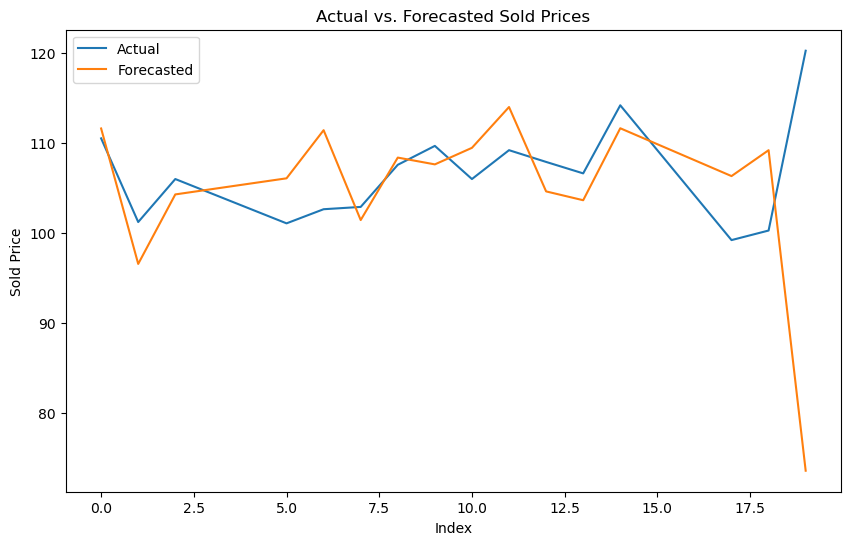

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Remove rows with missing values
final.dropna(inplace=True)

# Calculate mean absolute error
mae = mean_absolute_error(final['average_sold_price'], final['forecasted_sold_price'])

# Calculate mean squared error
mse = mean_squared_error(final['average_sold_price'], final['forecasted_sold_price'])

# Calculate accuracy, assuming a tolerance of 5% deviation from the actual price
tolerance = 0.05 * final['average_sold_price']
accuracy = np.mean(np.abs(final['average_sold_price'] - final['forecasted_sold_price']) <= tolerance) * 100

# Print evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)

# Plot actual vs. predicted sold prices
plt.figure(figsize=(10, 6))
plt.plot(final.index, final['average_sold_price'], label='Actual')
plt.plot(final.index, final['forecasted_sold_price'], label='Forecasted')
plt.xlabel('Index')
plt.ylabel('Sold Price')
plt.title('Actual vs. Forecasted Sold Prices')
plt.legend()
plt.show()